In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Pyspark/House_Price

/content/gdrive/MyDrive/Pyspark/House_Price


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkConf , SparkContext
from pyspark.sql import SparkSession , SQLContext


from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import udf , col

from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator , CrossValidatorModel
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark =SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [ ]:
df = spark.read.csv("/content/gdrive/MyDrive/Pyspark/House_Price/cal_housing.data",schema=schema)

In [ ]:
df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



Checking Missing Values

In [ ]:
df.select([f.count(f.when(f.isnull(column), column )).alias(column) for column in df.columns]).show()

+----+---+------+--------+--------+---+--------+------+-----+
|long|lat|medage|totrooms|totbdrms|pop|houshlds|medinc|medhv|
+----+---+------+--------+--------+---+--------+------+-----+
|   0|  0|     0|       0|       0|  0|       0|     0|    0|
+----+---+------+--------+--------+---+--------+------+-----+



EDA

Distribution of the median age of the people living in the area

In [ ]:
df.groupBy("medage").count().sort("medage",ascending=False).show()

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
|  42.0|  368|
|  41.0|  296|
|  40.0|  304|
|  39.0|  369|
|  38.0|  394|
|  37.0|  537|
|  36.0|  862|
|  35.0|  824|
|  34.0|  689|
|  33.0|  615|
+------+-----+
only showing top 20 rows



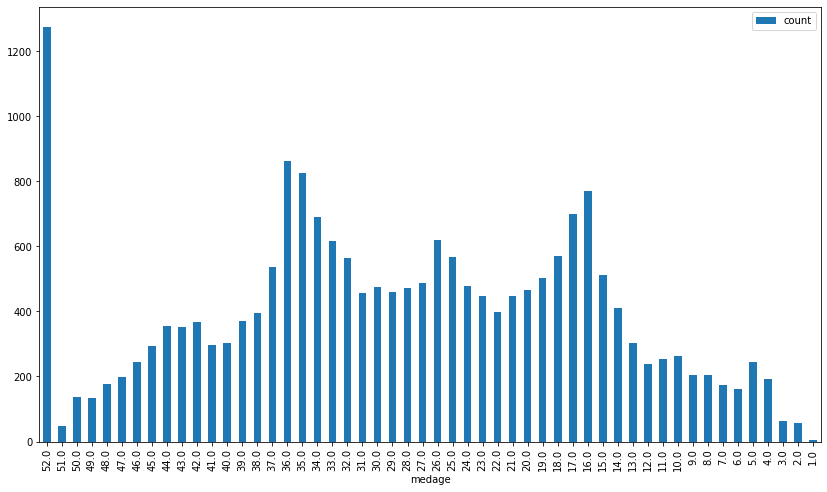

In [ ]:
df.groupBy("medage").count().sort("medage",ascending=False).toPandas().plot.bar(x="medage",figsize=(14,8))

Most of the People are in Youth or Settle here dusring there Senior Years.

In [ ]:
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|               long|              lat|            medage|          totrooms|         totbdrms|               pop|         houshlds|            medinc|             medhv|
+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|            20640|             20640|            20640|             20640|             20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev|  2.003531742932898|2.135952380602968| 12.58555761211163|2181.6152515827944| 421.247905943133|  

we need to Standardize our dataset as multiple columns have widevrange of values between max and min

Preprocessing the Target Value

In [ ]:
#we will express the house values in units of 100,000. 
#That means that a target such as 452600.000000 should become 4.526:
df = df.withColumn("medhv",col("medhv")/10000)

In [ ]:
df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|45.26|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|35.85|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|35.21|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|34.13|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|34.22|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows



feature Engineering

We will now add the following Columns

1. Rooms per household which refers to the number of rooms in households per block group.

2. Population per household, which basically gives us an indication of how many people live in households per block group.

3. Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

In [ ]:
df = (
    df.withColumn("rmsperhh",f.round(col("totrooms")/col("houshlds"),2))
    .withColumn("popperhh",f.round(col("pop")/col("houshlds"),2))
    .withColumn("bdrmperrm",f.round(col("totbdrms")/col("totrooms"),2)))

In [ ]:
df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+---------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+---------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|45.26|    6.98|    2.56|     0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|35.85|    6.24|    2.11|     0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|35.21|    8.29|     2.8|     0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|34.13|    5.82|    2.55|     0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|34.22|    6.28|    2.18|     0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+---------+
only showing top 5 rows



so from first row we are able to see there are 6.98 rooms per households , 2.5 people per house hold but the amount of room is very low 0.15

Now we will select necessary columns 

In [ ]:
df = df.select("medhv",  "totbdrms",  "pop",  "houshlds",  "medinc",  "rmsperhh", "popperhh", "bdrmperrm")

In [ ]:
feature_cols =[ "totbdrms",  "pop",  "houshlds",  "medinc",  "rmsperhh", "popperhh", "bdrmperrm"]

In [ ]:
#Use a VectorAssembler to put features into a feature vector column:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features") 

In [ ]:
df_vc = assembler.transform(df)

In [ ]:
df_vc.show(2)

+-----+--------+------+--------+------+--------+--------+---------+--------------------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmperrm|            features|
+-----+--------+------+--------+------+--------+--------+---------+--------------------+
|45.26|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|     0.15|[129.0,322.0,126....|
|35.85|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|     0.16|[1106.0,2401.0,11...|
+-----+--------+------+--------+------+--------+--------+---------+--------------------+
only showing top 2 rows



Standardization

In [ ]:
sc = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
# Fit the DataFrame to the scaler
scaled_df = sc.fit(df_vc).transform(df_vc)

In [ ]:
scaled_df.select('features','features_scaled').show(5)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[129.0,322.0,126....|[0.30623297630686...|
|[1106.0,2401.0,11...|[2.62553233949916...|
|[190.0,496.0,177....|[0.45104081781631...|
|[235.0,558.0,219....|[0.55786627466754...|
|[280.0,565.0,259....|[0.66469173151877...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

Train Test Split

In [ ]:
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=99)

Machine Learning

Linear Regression

In [ ]:
lr = LinearRegression(featuresCol='features_scaled', labelCol="medhv")

In [ ]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [ ]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [ ]:
predictions.show(5)

+-----+--------+------+--------+------+--------+--------+---------+--------------------+--------------------+-------------------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmperrm|            features|     features_scaled|         prediction|
+-----+--------+------+--------+------+--------+--------+---------+--------------------+--------------------+-------------------+
| 1.75|   168.0| 259.0|   138.0|2.3667|    3.57|    1.88|     0.34|[168.0,259.0,138....|[0.39881503891126...|  19.88778202475004|
| 2.25|    79.0| 167.0|    53.0|0.7917|    2.02|    3.15|     0.74|[79.0,167.0,53.0,...|[0.18753802424994...| 31.447228456801877|
| 2.25|  1743.0|6835.0|  1439.0|2.7138|    6.93|    4.75|     0.17|[1743.0,6835.0,14...|[4.13770602870438...|-1.0778392270174688|
|  2.5|    33.0|  64.0|    27.0|0.8571|    1.63|    2.37|     0.75|[33.0,64.0,27.0,0...|[0.07833866835757...|  32.48739765291832|
| 2.75|    24.0|  29.0|    15.0|1.2656|    6.47|    1.93|     0.25|[24.0,29.0,15.0,1...|[0

Evaluation

In [ ]:
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 7.6996498740875605
MAE: 5.63853707805161
R2: 0.5546925151930338


In [ ]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

RMSE: 7.8988056987624145
MAE: 5.629616206937359
R2: 0.5314852546050379


Decision Tree 

In [ ]:
dt = DecisionTreeRegressor(featuresCol='features_scaled', labelCol="medhv")\
# Fit the data to the model
dt_model = dt.fit(train_data)
# Generate predictions
predictions = dt_model.transform(test_data)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

RMSE: 7.364505578859604
MAE: 5.398776934089429
R2: 0.5927251492757921


Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(featuresCol='features_scaled', labelCol="medhv")\
# Fit the data to the model
rf_model = rf.fit(train_data)
# Generate predictions
predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

RMSE: 7.3544787039166435
MAE: 5.4812679310681816
R2: 0.5938334148475531


In [ ]:
gb = GBTRegressor(featuresCol='features_scaled', labelCol="medhv")\
# Fit the data to the model
gb_model = gb.fit(train_data)
# Generate predictions
predictions = gb_model.transform(test_data)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predictions)))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

RMSE: 7.067834581526645
MAE: 5.073268243700367
R2: 0.6248774644297763


From all the Machine Learning Models Gradient Boosting is giving us the best Result with RMSE: 7.06,
MAE: 5.07 and *R2*: 0.62